In [1]:
import pandas as pd
import numpy as np
import gudhi as gd
from gudhi.weighted_rips_complex import WeightedRipsComplex
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.point_cloud.dtm import DistanceToMeasure
from gudhi.hera import wasserstein_distance
from gudhi.representations import PersistenceImage, BettiCurve
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import pairwise_distances, silhouette_score
from joblib import Parallel, delayed
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy import signal
from scipy.stats import levy_stable
from symulacja_py import impsim
from tqdm.notebook import tqdm 
import matplotlib
import h5py
#%matplotlib widget

In [2]:
datapath ="./Dlotko_dane/text_files/"
filelist = os.listdir(datapath)
print(sorted(filelist))
filenames  =sorted(filelist)
signal_list = []
for filename in sorted(filelist):
    signal_list.append(np.loadtxt(datapath+filename))

['good_cond_Gauss.txt', 'good_cond_Gauss_ch_b.txt', 'sig1a.txt', 'sig1b.txt', 'sig2a.txt', 'sig2b.txt', 'sig3a.txt', 'sig3b.txt']


In [3]:
minlengeth = min([len(s) for s in signal_list])
for i in range(len(signal_list)):
    signal_list[i] = signal_list[i][:minlengeth]

IndexError: list index out of range

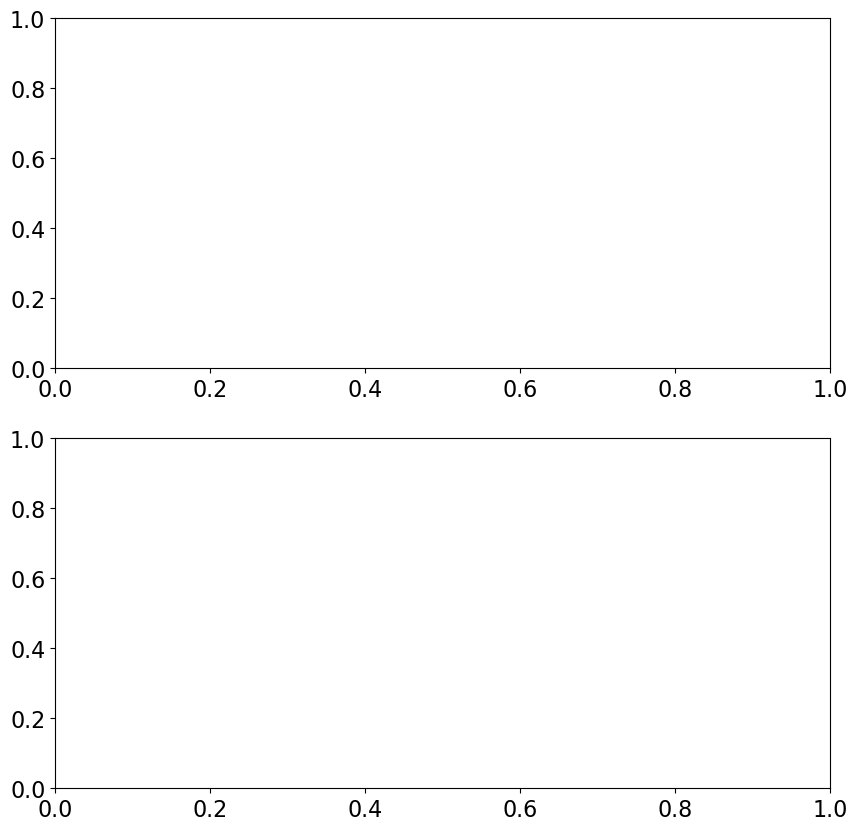

In [24]:
f,ax = plt.subplots(2,1, figsize =(10,10))
#ax[0].plot(signal_list[0])
#ax[0].plot(signal_list[2])

index0 = np.array_split(np.arange(len(signal_list[3])),n_samples)[0]
index26 = np.array_split(np.arange(len(signal_list[3])),n_samples)[26]
index29 = np.array_split(np.arange(len(signal_list[3])),n_samples)[29]
ax[1].plot(index0,signal_list[3][index0])
ax[1].plot(index26,signal_list[3][index26])
ax[1].plot(index29,signal_list[3][index29])
plt.show()

In [25]:
from gtda.time_series import takens_embedding_optimal_parameters
tau, dim = takens_embedding_optimal_parameters(signal_list[4],100,100, n_jobs = -1)
print(tau,dim)

KeyboardInterrupt: 

In [6]:
def compute_diagram(data, dim, delay, skip, normalize = True, weighted = True, point_cloud_size = 100):
    tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
    point_clouds = tde.transform([data])[0]
    if len(point_clouds>250):
        skip = max(len(point_clouds)//250,1)
        tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
        point_clouds = tde.transform([data])[0] 
    #point_clouds = levy_stable.rvs(alpha,0,0, size=(100,2))

    if (normalize):
        point_clouds = point_clouds-np.mean(point_clouds,1)[:, None]
        point_clouds = point_clouds/np.sqrt(np.sum(point_clouds**2, 1))[:, None]

    pc = point_clouds
    #print(len(pc))

    if weighted:
        dist = cdist(pc,pc)
        dtm = DistanceToMeasure(5, dim = 10, q=2, metric="precomputed")
        r = dtm.fit_transform(dist)
        ac = WeightedRipsComplex(distance_matrix=dist,weights = 1/r)
    else:
        ac = gd.RipsComplex(points=pc)
    
    st = ac.create_simplex_tree(max_dimension = 2)
    st.compute_persistence()
    pd = st.persistence_intervals_in_dimension(1)
    return pd

In [58]:
n_samples = 10
norms = np.zeros((len(signal_list),n_samples))
start = 0
end = 2
grid = np.linspace(start,end,10000)
bc = BettiCurve(predefined_grid=grid)
betti_curves = np.zeros((len(signal_list),n_samples,10000))




for j in tqdm(range(0,len(signal_list))):
    #scaling_factor =(j+2)*0.5    
    dim = 96#29#105#95#55#132#66#432#int(90*(1/(scaling_factor)))
    delay = 98#40#97#98#880#50#100#63#452#int(120*(1/(scaling_factor)**2))#int(90*scaling_factor)
    
    #print("Speed {}, dim = {}, delay = {}".format(speeds[j],dim,delay))
    
    skip =1
    samples = np.array_split(signal_list[j],n_samples)
        
    for k in range(0,len(samples)):
        pd = compute_diagram(samples[k], dim, delay, skip, normalize = True, weighted = False, point_cloud_size = 100)
        if j == 0 or j == 1:
            print(pd)
        #bc = np.array(compute_bc_from_ts(samples[k], dim, delay, skip))
        curve = np.array(bc.fit_transform([pd])[0])
        betti_curves[j,k] = curve
        #norm = compute_norms_from_ts(samples[k], dim, delay, skip)
        norm = wasserstein_distance(pd,[], order=1, internal_p = 1)

        norms[j,k] = norm

  0%|          | 0/8 [00:00<?, ?it/s]

[[1.08840624 1.08845541]
 [1.04609711 1.09053193]
 [1.09252133 1.09656632]
 [1.09202273 1.10042431]
 [1.08331402 1.10189704]
 [1.08375529 1.10253509]
 [1.09386641 1.1040487 ]
 [1.08796035 1.1044483 ]
 [1.07350575 1.10467454]
 [1.0618542  1.10467454]
 [1.10249273 1.10711995]
 [1.09667674 1.10711995]
 [1.08234232 1.10987689]
 [1.10206204 1.11016691]
 [1.10471636 1.1108344 ]
 [1.10232459 1.11203614]
 [1.11098884 1.11203614]
 [1.09663041 1.11212447]
 [1.09135955 1.11212447]
 [1.10076628 1.11249409]
 [1.11010704 1.11294973]
 [1.08510431 1.11309284]
 [1.10060107 1.11379444]
 [1.10880647 1.11412131]
 [1.11227816 1.1150689 ]
 [1.05020355 1.11697275]
 [1.08994191 1.11710686]
 [1.05115337 1.11741314]
 [1.10794437 1.11771588]
 [1.10649891 1.11804698]
 [1.10692916 1.11823812]
 [1.08931814 1.11823812]
 [1.11286168 1.11847237]
 [1.10368943 1.11847237]
 [1.11206889 1.11867761]
 [1.11298282 1.11970941]
 [1.1074     1.12147112]
 [1.08169677 1.12172671]
 [1.10652052 1.12309732]
 [1.08321701 1.12309732]


[[0.99205838 1.00814047]
 [1.03606483 1.04225083]
 [1.04427825 1.04602289]
 [1.04264675 1.04737863]
 [1.03335879 1.06634434]
 [1.06309802 1.06698336]
 [1.06618009 1.07020866]
 [1.06523213 1.07020866]
 [1.06116452 1.07220193]
 [1.06639245 1.07406579]
 [1.06330866 1.07452976]
 [1.05654724 1.07554984]
 [1.075669   1.0780009 ]
 [1.05944749 1.0780009 ]
 [1.07546716 1.07807986]
 [1.04993485 1.07888945]
 [1.06846804 1.07914675]
 [1.0780203  1.07957836]
 [1.05260119 1.07998524]
 [1.0719385  1.08018516]
 [1.07402349 1.08168192]
 [1.08088017 1.08357543]
 [1.07624686 1.08357543]
 [1.07919326 1.08360673]
 [1.07192503 1.08360673]
 [1.06655972 1.08389073]
 [1.06434889 1.08431496]
 [1.07634303 1.08438964]
 [1.07568998 1.08457595]
 [1.06010633 1.08457595]
 [1.07218094 1.08568601]
 [1.08462066 1.08620073]
 [1.08429269 1.08674788]
 [1.06060065 1.0870467 ]
 [1.07396308 1.08709072]
 [1.06457653 1.08742186]
 [1.06322025 1.08817563]
 [1.07364051 1.0886142 ]
 [1.04623289 1.08879229]
 [1.07071528 1.08879229]


[[1.19717151 1.20334486]
 [1.18778347 1.2038721 ]
 [1.2190698  1.22499656]
 ...
 [1.31658529 1.32710328]
 [1.27115881 1.32958205]
 [1.33103479 1.34171372]]
[[1.15234267 1.1534351 ]
 [1.15146054 1.15989771]
 [1.16351184 1.16818825]
 ...
 [1.31164784 1.32643241]
 [1.3288726  1.33626708]
 [1.32750452 1.33933183]]
[[1.10512484 1.12895287]
 [1.10642045 1.13052949]
 [1.12445549 1.13092485]
 [1.12631923 1.13469481]
 [1.12597344 1.13513556]
 [1.13195238 1.1377222 ]
 [1.13602222 1.13847844]
 [1.13987479 1.14057475]
 [1.1018128  1.14057475]
 [1.11511756 1.14083977]
 [1.12437715 1.1429437 ]
 [1.14327489 1.14421215]
 [1.1262432  1.1462324 ]
 [1.12351001 1.14658773]
 [1.12249218 1.14746221]
 [1.11670856 1.1478522 ]
 [1.11995544 1.1485501 ]
 [1.14800491 1.1488827 ]
 [1.14667687 1.15049905]
 [1.13705246 1.15108171]
 [1.12782232 1.15120428]
 [1.14595303 1.15187924]
 [1.12885916 1.15279466]
 [1.13622494 1.15338573]
 [1.1054564  1.15338573]
 [1.11684733 1.15478582]
 [1.14005649 1.15586923]
 [1.14814073 

[[1.13951879 1.14338208]
 [1.132767   1.15560584]
 [1.13999274 1.15719919]
 ...
 [1.29063077 1.31724378]
 [1.29319243 1.31853629]
 [1.31608522 1.322456  ]]
[[1.15027307 1.15478507]
 [1.15423047 1.15846869]
 [1.14483959 1.16268618]
 ...
 [1.27673146 1.32352473]
 [1.32333677 1.32460477]
 [1.26017477 1.33178397]]
[[1.16844843 1.1820958 ]
 [1.16320818 1.18252953]
 [1.17686679 1.18600582]
 ...
 [1.32409745 1.33295342]
 [1.3331432  1.33548225]
 [1.34084929 1.34575684]]
[[1.11521099 1.12160885]
 [1.11206814 1.12608347]
 [1.1261443  1.1277084 ]
 [1.12232718 1.12828864]
 [1.11195987 1.13165887]
 [1.1234287  1.13737106]
 [1.12398398 1.13806189]
 [1.10629864 1.14043789]
 [1.11575301 1.14043789]
 [1.11526069 1.14069863]
 [1.10722256 1.14078051]
 [1.10718061 1.14242345]
 [1.11519363 1.14402628]
 [1.13814501 1.14407151]
 [1.1428962  1.14718789]
 [1.13690292 1.1477961 ]
 [1.12100922 1.14798383]
 [1.14630053 1.15064002]
 [1.12512341 1.15064002]
 [1.12910947 1.15137991]
 [1.14189303 1.15164167]
 [1.145

[[1.06843284 1.09402597]
 [1.09823605 1.09974506]
 [1.10087532 1.10119932]
 [1.10461764 1.10538322]
 [1.09475911 1.10649033]
 [1.09731953 1.11198667]
 [1.10750045 1.1128052 ]
 [1.10762646 1.11286374]
 [1.10152387 1.11352369]
 [1.11197581 1.1153096 ]
 [1.10965814 1.11534111]
 [1.10756621 1.11768436]
 [1.11191616 1.11902636]
 [1.09398327 1.11904514]
 [1.09198079 1.11948047]
 [1.08734755 1.11966689]
 [1.11046259 1.12077354]
 [1.11469462 1.12077354]
 [1.11082957 1.12244457]
 [1.12059997 1.12291421]
 [1.10415907 1.12291421]
 [1.10961034 1.12307092]
 [1.11667106 1.12308389]
 [1.11429596 1.12316046]
 [1.10794602 1.12449092]
 [1.08803012 1.1251148 ]
 [1.10228271 1.12545626]
 [1.12381645 1.12572593]
 [1.11285183 1.12626196]
 [1.12094521 1.12679601]
 [1.10520738 1.12833812]
 [1.09329896 1.1292562 ]
 [1.12842501 1.12974328]
 [1.09934058 1.13050586]
 [1.11188167 1.13189459]
 [1.11562379 1.13189459]
 [1.11874311 1.13238686]
 [1.11042184 1.13316905]
 [1.10404284 1.1340343 ]
 [1.12257241 1.1340343 ]


[[1.09679893 1.10524308]
 [1.09939907 1.11410569]
 [1.11428574 1.11968413]
 ...
 [1.30206616 1.31202356]
 [1.19830354 1.31292853]
 [1.24743647 1.31597649]]
[[1.06727314 1.08068531]
 [1.06008741 1.09133064]
 [1.07274158 1.09133064]
 [1.08961437 1.09166897]
 [1.08699007 1.09488683]
 [1.09699022 1.09750231]
 [1.07125866 1.09789455]
 [1.09509567 1.10167398]
 [1.07028407 1.103438  ]
 [1.08924338 1.10736506]
 [1.10343892 1.10849584]
 [1.10096212 1.1093628 ]
 [1.0840344  1.10940603]
 [1.09553733 1.11070216]
 [1.10492605 1.11381211]
 [1.11165924 1.11422848]
 [1.06664299 1.11498152]
 [1.10990433 1.11531821]
 [1.09574787 1.11535709]
 [1.10972377 1.11661104]
 [1.1155229  1.11717057]
 [1.10875946 1.11717057]
 [1.10476017 1.11717057]
 [1.10684259 1.11834093]
 [1.0982589  1.11949116]
 [1.06326578 1.11949116]
 [1.09874282 1.11949116]
 [1.1177375  1.12153119]
 [1.11245117 1.12290904]
 [1.09684769 1.12326415]
 [1.09253336 1.12326415]
 [1.0926956  1.12348405]
 [1.11404033 1.12405253]
 [1.10491131 1.1247

[[1.22073223 1.22568204]
 [1.21518229 1.22856674]
 [1.23314166 1.23512582]
 ...
 [1.30477011 1.32573159]
 [1.27317664 1.32573159]
 [1.33049817 1.33079396]]
[[1.16712988 1.17174027]
 [1.21125645 1.2114838 ]
 [1.20833188 1.21354731]
 ...
 [1.32682791 1.32752204]
 [1.32741772 1.32826404]
 [1.28692807 1.32973373]]
[[1.1415995  1.14744354]
 [1.12007127 1.15185861]
 [1.14694871 1.16423531]
 ...
 [1.26709306 1.32516796]
 [1.32080565 1.32729809]
 [1.29024069 1.32923343]]
[[1.15582357 1.15605572]
 [1.1556351  1.16905177]
 [1.16834649 1.1798285 ]
 ...
 [1.30329297 1.32426533]
 [1.30482848 1.32571016]
 [1.33425394 1.34563163]]
[[1.19307729 1.20884073]
 [1.20284921 1.21886724]
 [1.21645333 1.22171466]
 ...
 [1.29631031 1.32343886]
 [1.31791489 1.32373936]
 [1.314187   1.32839577]]
[[1.16599195 1.19228576]
 [1.17037867 1.20751451]
 [1.19689289 1.21390119]
 ...
 [1.24480244 1.32769182]
 [1.32683761 1.32969785]
 [1.31880746 1.33426906]]
[[1.13982637 1.14163382]
 [1.10878535 1.14814548]
 [1.14677505 1

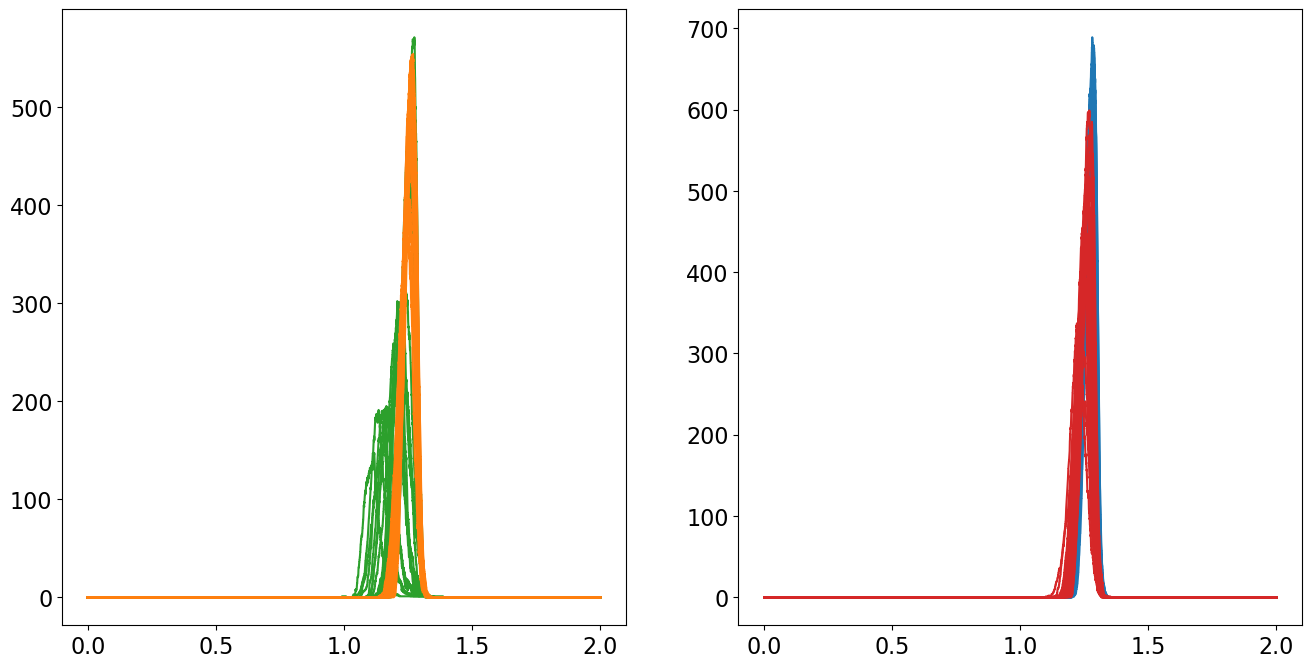

In [59]:
f,ax = plt.subplots(1,2,figsize=(16,8))
for j in [0,1,4,5]:
    for k in range(0,len(samples)):
        ax[0].plot(grid, betti_curves[j][k], color=colors[j//2])
for j in [2,3,6,7]:
    for k in range(0,len(samples)):
        ax[1].plot(grid, betti_curves[j][k], color=colors[j//2])
plt.show()

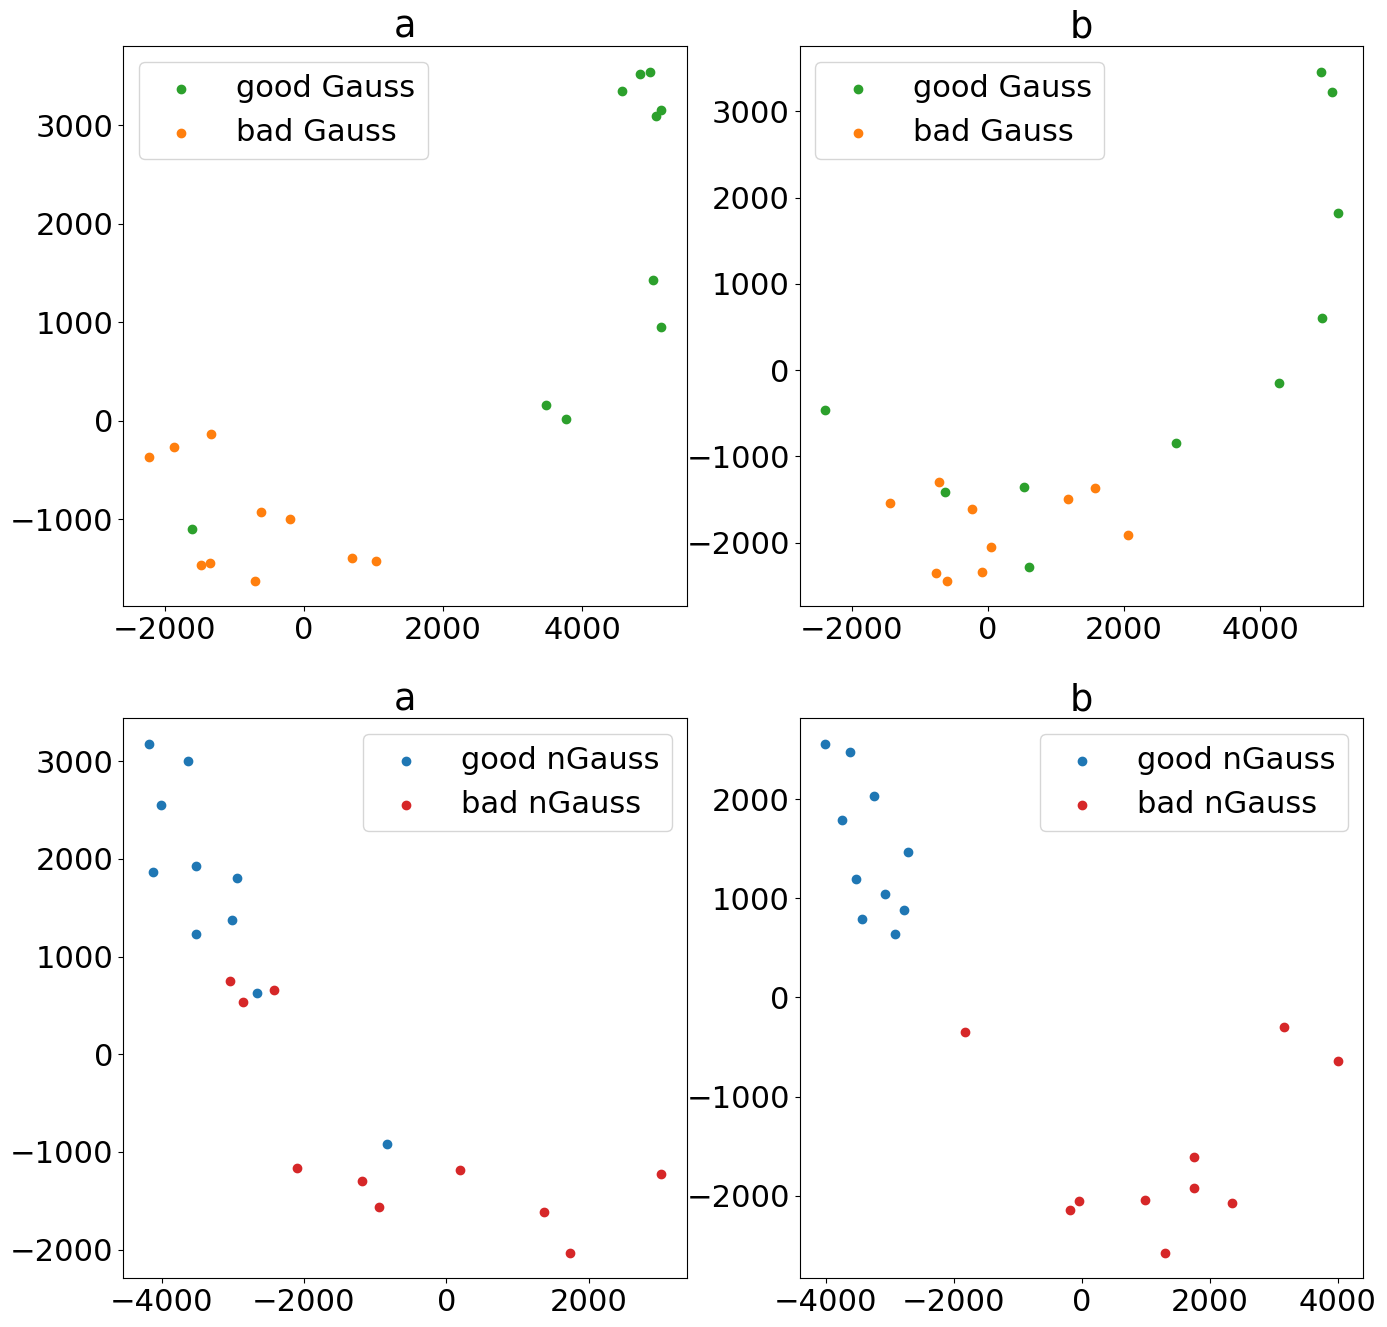

explained variance: [0.67344425 0.25820883 0.044353  ]
silhouette score 0.16150223391643634


In [60]:
plt.rc('font', **{'size'   : 22})
pca = PCA(n_components=3)
pca.fit_transform([betti_curves[j,k] for j in range(0,len(signal_list)) for k in range(0,n_samples)])
labels = np.repeat([1,2,3,4], 2*n_samples)
names = ["good Gauss", "good nGauss", "bad Gauss", "bad nGauss"]
fig,ax = plt.subplots(2,2,figsize=(16,16))
#ax.scatter(emb[:,0],emb[:,1])#,  marker = "o", c=t, label="malfunctioning machine {}".format(i))
colors = ["tab:green", "tab:blue", "tab:orange", "tab:red"]
##############Horizontal:0,2 ----------Vertical:1,3
for i in [0,2]:
    
    emb_a = pca.transform(betti_curves[2*i,:])
    ax[0,0].scatter(emb_a[:,0],emb_a[:,1], marker = "o", c=colors[i], label=names[i])    
    ax[0,0].set_title("a")
    ax[0,0].legend()
    
    emb_b = pca.transform(betti_curves[2*i+1,:])
    ax[0,1].scatter(emb_b[:,0],emb_b[:,1], marker = "o", c=colors[i], label=names[i])
    ax[0,1].set_title("b")
    ax[0,1].legend()

for i in [1,3]:
    
    emb_a = pca.transform(betti_curves[2*i,:])
    ax[1,0].scatter(emb_a[:,0],emb_a[:,1], marker = "o", c=colors[i], label=names[i])    
    ax[1,0].set_title("a")
    ax[1,0].legend()
    
    emb_b = pca.transform(betti_curves[2*i+1,:])
    ax[1,1].scatter(emb_b[:,0],emb_b[:,1], marker = "o", c=colors[i], label=names[i])
    ax[1,1].set_title("b")
    ax[1,1].legend()
    
    
#for i in range(len(emb_a)):
#    ax[0].text(emb_a[i,0], emb_a[i,1], i)

#ax.flat[0].set_xlim(-550,50)
#ax.flat[0].set_ylim(-30,50)

#ax.flat[1].set_xlim(-20,20)
#ax.flat[1].set_ylim(-30,50)

plt.savefig("crusher_results/CrusherPCA.pdf")
plt.show()
print("explained variance:", pca.explained_variance_ratio_)
print("silhouette score",silhouette_score(betti_curves.reshape(8*n_samples, len(grid)), labels))

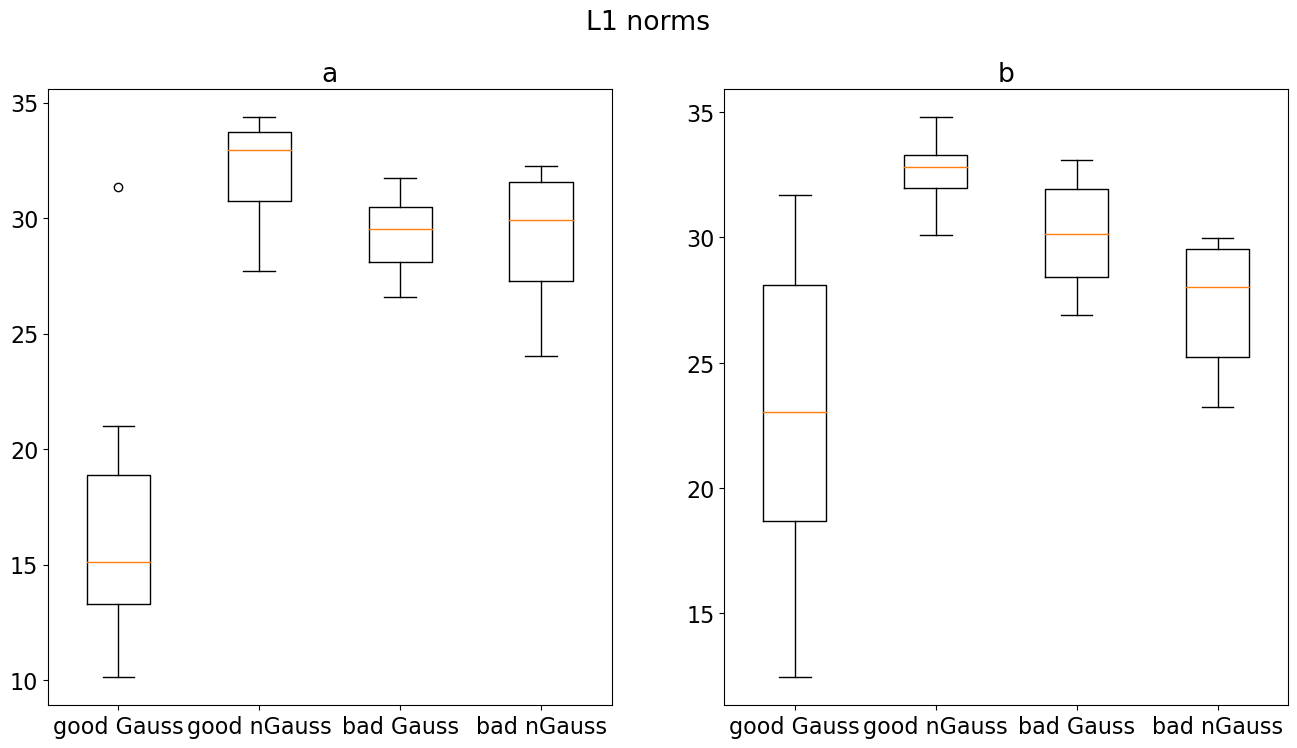

In [61]:
#font = {'size'   : 22}

plt.rc('font', **{'size'   : 16})
fig,ax = plt.subplots(1,2,figsize=(16,8))

ax[0].boxplot([norms[0,:],norms[2,:],norms[4,:],norms[6,:]])
ax[0].set_title("a")
ax[0].set_xticklabels(names)
 
ax[1].boxplot([norms[1,:],norms[3,:],norms[5,:],norms[7,:]])
ax[1].set_title("b")
ax[1].set_xticklabels(names)
          
fig.suptitle("L1 norms")
plt.savefig("crusher_results/CrusherBoxplot.pdf")
plt.show()

In [51]:
#grid search

n_samples = 10

start = 0
end = 2
grid = np.linspace(start,end,10000)
bc = BettiCurve(predefined_grid=grid)
labels = np.repeat([1,2,3,4], 2*n_samples)

def compute_curve_scores(dim, delay):
    if dim*delay > 48400:
        return 0
    betti_curves = np.zeros((len(signal_list),n_samples,10000))
    for j in tqdm(range(0,len(signal_list))):


        #print("Speed {}, dim = {}, delay = {}".format(speeds[j],dim,delay))

        skip =1
        samples = np.array_split(signal_list[j],n_samples)

        for k in range(0,len(samples)):
            #print(i,j,k)
            dgm = compute_diagram(samples[k], dim, delay, skip, normalize = True, weighted = False, point_cloud_size = 100)
            #bc = np.array(compute_bc_from_ts(samples[k], dim, delay, skip))
            curve = np.array(bc.fit_transform([dgm])[0])
            betti_curves[j,k] = curve
            #norm = compute_norms_from_ts(samples[k], dim, delay, skip)
    
    clf = SVC(kernel="linear")
    #gaussian: 0145, non-gaussian:2367
    clf.fit([betti_curves[j,k] for j in [2,3,6,7] for k in range(0,n_samples)], np.repeat([0,1], 2*n_samples))
    return np.linalg.norm(clf.coef_[0])
    #return(silhouette_score(betti_curves.reshape(8*n_samples, len(grid)), labels))

def search_hyperbola(p):
    vals = np.geomspace(np.sqrt(p),np.sqrt(p)*p,int(p-112), dtype=int)
    labels = np.repeat([1,2,3,4], 2*n_samples)    
    scores = Parallel(n_jobs=-1)(delayed(compute_curve_scores)(vals[i], vals[-(i+1)]) for i in range(0,len(vals)))
                
    return np.array(scores)
    

#product = np.linspace(115,124,10)
dels = np.linspace(95,105,11)
dims = np.linspace(95,105,11)
#scores = Parallel(n_jobs=-1)(delayed(search_hyperbola)(p) for p in product)
scores = Parallel(n_jobs=-1)(delayed(compute_curve_scores)(int(i),int(j)) for i in dims for j in dels)

  0%|          | 0/8 [00:00<?, ?it/s]


In [52]:
print(dims, dels)
print(scores)
print(np.max(scores), np.argmax(scores))

[ 95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.] [ 95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.]
[0.05636785213905452, 0.023145895558856117, 0.02377992186538283, 0.0199266871106924, 0.0281104561001481, 0.028249559043074607, 0.02943105690755347, 0.032980866384934936, 0.033741658404789224, 0.021688159624962875, 0.01180760062397697, 0.02137600818483059, 0.01785674242885066, 0.026062287117816895, 0.019606914524071224, 0.03148806662781059, 0.032338942135539436, 0.02468541683613244, 0.02740420230800164, 0.02385530492416969, 0.014583736619086038, 0.012054393809114869, 0.0247523053210075, 0.02113896046904922, 0.0290302641316869, 0.016692117164307452, 0.015662164101200974, 0.03541457823369485, 0.029143995896816408, 0.008344500266817257, 0.02170036789995624, 0.013955312736426655, 0.017589473475589562, 0.026900757941533383, 0.028107695329645424, 0.02484666312429759, 0.005116478571789017, 0.021166011994419077, 0.04014834019876997, 0.014471424381411602, 0.010485637919018324, 0.0208

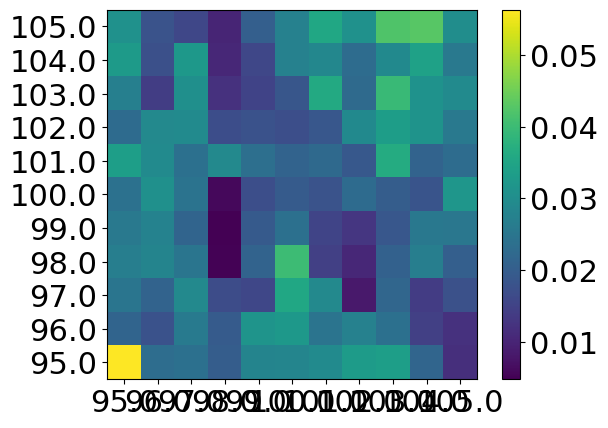

  0%|          | 0/8 [00:00<?, ?it/s]


In [53]:
np.array(scores).reshape((len(dims),len(dels)))
f,ax=plt.subplots()

img = ax.imshow(np.array(scores).reshape((len(dims),len(dels))), origin="lower")
plt.colorbar(img)

ax.set_xticks(range(len(dels)))
ax.set_yticks(range(len(dims)))
ax.set_xticklabels(dels)
ax.set_yticklabels(dims)

plt.show()

In [209]:
indices = set()
for p in product:
    indices = indices | set(np.geomspace(1,p*p,int(p/10), dtype=int))
    
indices = np.array(list(indices))
indices.sort()

   

NameError: name 'product' is not defined

In [210]:
df = pd.DataFrame(0, index=indices, columns=indices)

for i in range(len(scores)):
    p=product[i]
    vals = np.geomspace(1,p*p,int(p/10), dtype=int)
    for j in range(len(scores[i])):
        print(vals[j],vals[-(j+1)], scores[i][j])
        df.at[vals[j],vals[-(j+1)]] = scores[i][j]
        

df

AttributeError: 'numpy.ndarray' object has no attribute 'DataFrame'

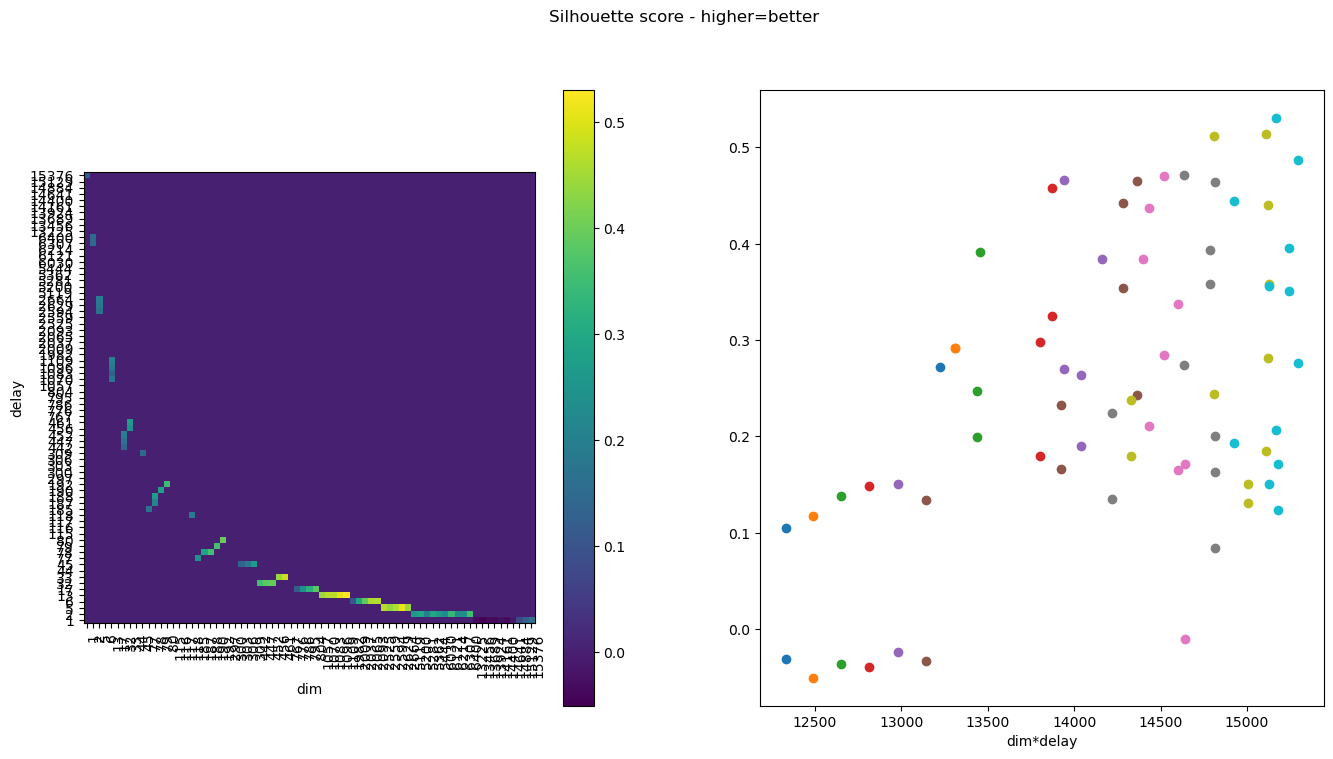

In [437]:
f,ax = plt.subplots(1,2,figsize=(16,8))
im = ax[0].imshow(df, origin="lower")
plt.colorbar(im)
ax[0].set_xticks(range(len(indices)))
ax[0].set_yticks(range(len(indices)))
ax[0].set_xticklabels(indices)
ax[0].set_yticklabels(indices)
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
ax[0].set_xlabel("dim")
ax[0].set_ylabel("delay")

for i in range(len(scores)):
    p = product[i]
    vals = np.geomspace(np.sqrt(p),np.sqrt(p)*p,int(p-112), dtype=int)
    ax[1].scatter(vals*np.flip(vals), scores[i])
ax[1].set_xlabel("dim*delay")

plt.suptitle("Silhouette score - higher=better")
plt.show()

In [75]:
clf = SVC(kernel="linear")
#gaussian
clf.fit([betti_curves[j,k] for j in [0,1,4,5] for k in range(0,n_samples)], np.repeat([0,1], 2*n_samples))
gauss_score = clf.score([betti_curves[j,k] for j in [0,1,4,5] for k in range(0,n_samples)], np.repeat([0,1], 2*n_samples))
clf.fit([betti_curves[j,k] for j in [2,3,6,7] for k in range(0,n_samples)], np.repeat([0,1], 2*n_samples))
ngauss_score = clf.score([betti_curves[j,k] for j in [2,3,6,7] for k in range(0,n_samples)], np.repeat([0,1], 2*n_samples))
print("gaussian score:", gauss_score)
print("non-gaussian score:", ngauss_score)

gaussian score: 1.0
non-gaussian score: 1.0


In [63]:
np.linalg.norm(clf.coef_[0])

0.03841559589609244

In [64]:
bcs = np.array([betti_curves[j,k] for j in [0,1,4,5] for k in range(0,n_samples)])
sum((bcs != 0).any(axis=0))


1848

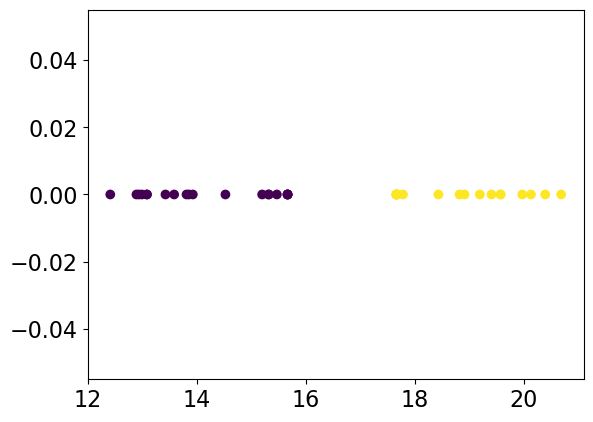

In [77]:
projection = np.dot(np.array([betti_curves[j,k] for j in [2,3,6,7] for k in range(0,n_samples)]), clf.coef_[0])
f,ax = plt.subplots()
ax.scatter(projection, [0]*40, c= np.repeat([0,1], 2*n_samples))
plt.show()

In [103]:
bcs = np.array([betti_curves[j,k] for j in [2,3,6,7] for k in range(0,n_samples)])
X=bcs
y = np.repeat([0,1], 2*n_samples)
from sklearn.model_selection import train_test_split
score_list = []
for seed in range(100):
    clf = SVC(kernel="linear")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed, stratify=y)
    #print(y_train.sum(), y_test.sum())
    clf.fit(X_train, y_train)
    score_list.append(clf.score(X_test, y_test))
    

0.8440000000000001 0.061351446600711845


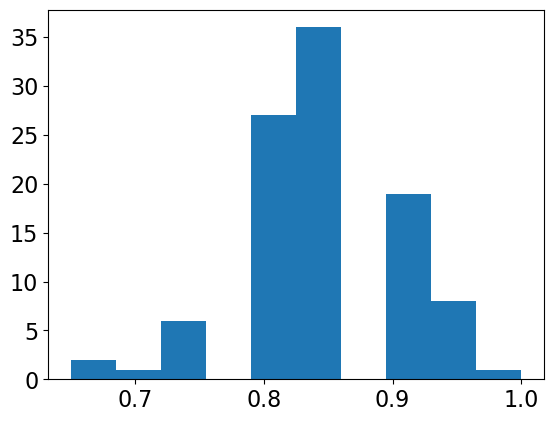

In [104]:
plt.hist(score_list)
print(np.mean(score_list), np.std(score_list))